[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UM-RMRS/raster_tools/blob/main/notebooks/SampleDesign.ipynb)

# Sample Design 
## This notebook demonstrates how to create random and systematic sample designs.
### Author: John Hogland 4/26/2023

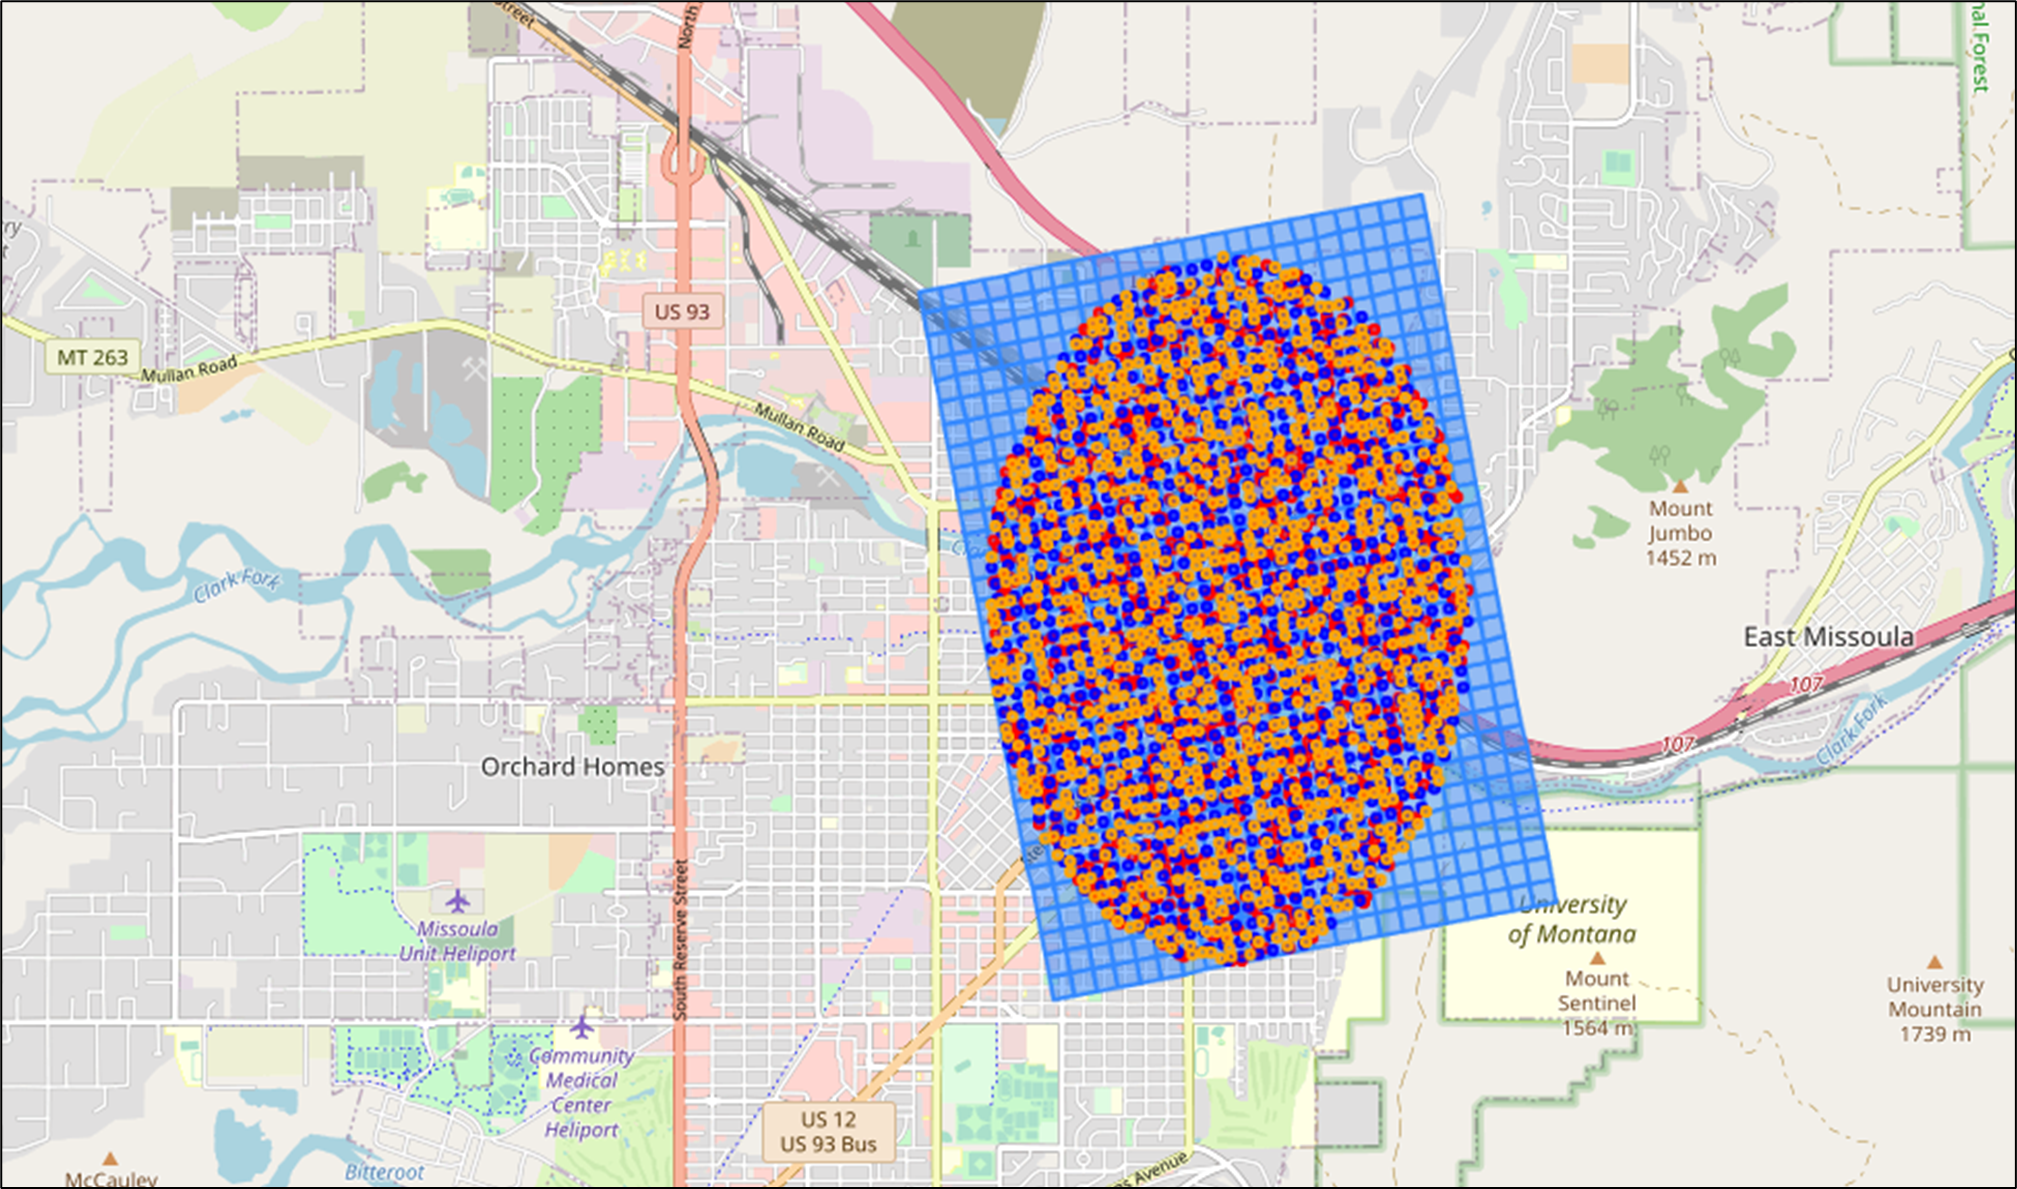

## Install packages

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install plotly
!pip install raster_tools

## The Process
### In this notebook we explore building various samples designs using Raster Tools.  


### Steps
1. Import python libraries 
2. Select a area of interest
3. Create a simple random sample
5. Create a stratified random sample

## Step 1: Import libraries and get data
### Import libary

In [ ]:
import matplotlib.pyplot as plt
import raster_tools
import numpy as np
import geopandas as gpd

from shapely import geometry
from shapely.geometry import shape

## Step 2: Select a area of interest (Missoula MT)

In [ ]:
loc = {"type": "Point", "coordinates": [-113.994, 46.8721]}

geom = shape(loc)
geom_buff = gpd.GeoSeries(
    geom.buffer(0.02), crs="EPSG:4326"
)  # buffer out 0.02 degrees to get an area
geom_p = geom_buff.to_crs("EPSG:5070")  # project to Albers
geom_buff.explore()  # Visualize

## Step 2: Create samples 
- create functions
- create a random sample of spatial locations (1090)
- create a systematic random sample
- create a systematic random sample spread on tiles

### Create definitions

In [ ]:
def get_fishnet(geom_p, lng):
    """
    tiles the bounds of the geometry into squares

    parameters:

    geom_p = (poly) geometry of the polygon to be sampled
    lng = (float) length of each square's side (map units)

    returns: geodataframe of tiles (polygons)

    """
    xmin, ymin, xmax, ymax = geom_p.total_bounds
    x, y = (xmin, ymin)
    geom_lst = []
    while y <= ymax:
        while x <= xmax:
            geom = geometry.Polygon(
                [
                    (x, y),
                    (x, y + lng),
                    (x + lng, y + lng),
                    (x + lng, y),
                    (x, y),
                ]
            )
            geom_lst.append(geom)
            x += lng

        x = xmin
        y += lng

    return gpd.GeoDataFrame(geom_lst, columns=["geometry"], crs=geom_p.crs)


def _samp_c(x, size):
    cnt = x.shape[0]
    if cnt >= size:
        return x.sample(size)


def get_tiled_pnts(geom_p, min_dist=60, area=20000, n=2):
    """
    produces a systematic sample with a random start that assures all points are at least a specified minium distance and that at least a specfied number of observations fall within a specifed area

    parameters:

    geom_p = (poly) geometry of the polygon to be sampled
    min_dist = (float) minimum distance between sample locations
    area = (float) tile size in map units
    n = total number of observations

    returns: geodataframe of point locations

    """
    xmin, ymin, xmax, ymax = geom_p.total_bounds
    xdif = xmax - xmin
    lng = np.sqrt(area)
    rx, ry = np.random.random(2) * lng / 2
    xs = np.arange(xmin + rx, xmax, min_dist)
    ys = np.arange(ymin + ry, ymax, min_dist)
    xv, yv = np.meshgrid(xs, ys)
    xv = xv.flatten()
    yv = yv.flatten()
    xind = (xv - xmin) // lng
    yind = (yv - ymin) // lng
    clms = xdif // lng + 1
    cind = yind * clms + xind
    pnts = gpd.points_from_xy(x=xv, y=yv)
    pnts_check = pnts.intersects(geom_p.unary_union)
    pnts = pnts[pnts_check]
    cind = cind[pnts_check]
    dic = {"cind": cind, "geometry": pnts}
    gdf = gpd.GeoDataFrame(dic, crs=geom_p.crs)
    return gdf.groupby("cind", group_keys=False).apply(lambda x: _samp_c(x, n))


def get_random_sample(geom_p, n=1000):
    """
    produces a random sample given a geometry

    parameters:
    geom_p = (polygon) project polygon
    n = number of observations

    returns: geodataframe of point locations

    """
    xmin, ymin, xmax, ymax = geom_p.total_bounds
    xdif = xmax - xmin
    ydif = ymax - ymin
    pnts_lst = []
    while len(pnts_lst) < n:
        x = (np.random.random() * xdif) + xmin
        y = (np.random.random() * ydif) + ymin
        pnt = geometry.Point([x, y])
        if pnt.intersects(geom_p).values:
            pnts_lst.append(pnt)

    dic = {"geometry": pnts_lst}
    gdf = gpd.GeoDataFrame(dic, crs=geom_p.crs)

    return gdf


def get_systematic_sample(geom_p, xdist, ydist):
    """
    produces a systematic random sample

    parameters:
    geom_p = (polygon) project polygon
    xdist = distance in easting (lon) between observations
    ydist = distance in northing (lat) between observations

    returns: geodataframe of point locations
    """
    xmin, ymin, xmax, ymax = geom_p.total_bounds
    rx = np.random.random() * xdist / 2
    ry = np.random.random() * ydist / 2
    xs = np.arange(xmin + rx, xmax, xdist)
    ys = np.arange(ymin + ry, ymax, ydist)
    xv, yv = np.meshgrid(xs, ys)
    xv = xv.flatten()
    yv = yv.flatten()
    pnts = gpd.points_from_xy(x=xv, y=yv)
    pnts_check = pnts.intersects(geom_p.unary_union)
    pnts = pnts[pnts_check]
    dic = {"geometry": pnts}
    gdf = gpd.GeoDataFrame(dic, crs=geom_p.crs)
    return gdf

## Create samples and visualize

In [ ]:
import folium

r_smp = get_random_sample(geom_p, 1090)
s_smp = get_systematic_sample(geom_p, 100, 100)
t_smp = get_tiled_pnts(geom_p, 60, 20000, 2)
fnet = get_fishnet(geom_p, np.sqrt(20000))

print("Simple Random sample n = " + str(r_smp.shape[0]))
print("Systematic Random sample n = " + str(s_smp.shape[0]))
print("Tiled Random sample n = " + str(t_smp.shape[0]))

m0 = fnet.explore(name="Tiles")
m1 = r_smp.explore(m=m0, color="red", name="Simple Random")
m2 = s_smp.explore(m=m1, color="blue", name="Systematic Random")
m3 = t_smp.explore(m=m2, color="orange", name="Tile Random")
folium.LayerControl().add_to(m3)
m3

# This ends the Sample Design notebook
## Check out the other notebooks:
- https://github.com/UM-RMRS/raster_tools/tree/main/notebooks
## References
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html